In [1]:
import sys
sys.path.append("../")

from torch import nn
from data_utils import load_mnist, load_usps
from models import DomainAdaptationNetwork, ProjectorNetwork

import torch
from torch.nn import functional as F
import numpy as np
from train import train_domain_adaptation
from utils import test_network, plot_target_cross_domain_swapping, plot_tsne

In [2]:
torch.manual_seed(0)
import numpy as np
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_space_dim, conv_feat_size, nb_channels=3):
        super(Decoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.conv_feat_size = conv_feat_size

        self.deco_dense = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features=np.prod(self.conv_feat_size)),
            nn.ReLU(True),
        )

        self.deco_fetures = nn.Sequential(
            nn.Conv2d(in_channels=self.conv_feat_size[0], out_channels=75, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=75, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=50, out_channels=1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z_task, z_spe):
        z = torch.cat([z_task, z_spe], 1)
        feat_encode = self.deco_dense(z)
        feat_encode = feat_encode.view(-1, *self.conv_feat_size)
        y = self.deco_fetures(feat_encode)

        return y


class Encoder(nn.Module):
    def __init__(self, latent_space_dim, img_size, nb_channels=3):
        super(Encoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.nb_channels = nb_channels

        self.conv_feat = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=50, out_channels=75, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(75),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=75, out_channels=100, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(100),
        )

        self.conv_feat_size = self.conv_feat(torch.zeros(1, *img_size)).shape[1:]
        self.dense_feature_size = np.prod(self.conv_feat_size)

        self.dense_feat = nn.Linear(in_features=self.dense_feature_size, out_features=1024)
        self.task_feat = nn.Linear(in_features=1024, out_features=latent_space_dim)
        self.source_feat = nn.Linear(in_features=1024, out_features=latent_space_dim)
        self.target_feat = nn.Linear(in_features=1024, out_features=latent_space_dim)

    def forward(self, input_data, mode='all'):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = F.relu(self.dense_feat(feat))
        if mode == 'task':
            z_task = F.relu(self.task_feat(feat))
            return z_task
        
        elif mode == 'source':
            z_source = F.relu(self.source_feat(feat))
            return z_source
        
        elif mode == 'target':
            z_target = F.relu(self.target_feat(feat))
            return z_target
        
        else:
            z_task = F.relu(self.task_feat(feat))
            z_source = F.relu(self.source_feat(feat))
            z_target = F.relu(self.target_feat(feat))
            return z_task, z_source, z_target        


In [4]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
from utils import show_decoded_images
from models import GradReverse

criterion_reconstruction = nn.BCELoss()
criterion_classifier = nn.NLLLoss(reduction='mean')
criterion_weighted_classifier = nn.NLLLoss(reduction='none')
criterion_disentangle = nn.MSELoss()
criterion_distance = nn.MSELoss()
criterion_triplet = nn.TripletMarginLoss(margin=1)

criterion_reconstruction = nn.BCELoss()
disentangle_criterion = nn.MSELoss()
criterion_classifier = nn.NLLLoss(reduction='mean')
criterion_triplet = nn.TripletMarginLoss(margin=1)

def train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader, betas,
                            alpha=1, gamma=1, delta=0.1, epochs=30, show_images=False):

    t = tqdm(range(epochs))
    for epoch in t:
        total_loss = 0
        corrects_source, corrects_target = 0, 0
        total_source, total_target = 0, 0

        # random images used for disentanglement
        #xs_rand = next(iter(source_train_loader))[0].cuda()
        #xt_rand = next(iter(target_train_loader))[0].cuda()

        for (x_s, y_s), (x_t, y_t) in zip(source_train_loader, target_train_loader):
            loss = 0
            x_s, y_s, x_t, y_t = x_s.cuda(), y_s.cuda(), x_t.cuda(), y_t.cuda()
            min_len = min(len(x_s), len(x_t))
            x_s, y_s, x_t, y_t = x_s[:min_len], y_s[:min_len], x_t[:min_len], y_t[:min_len]
            # target batch
            xt_hat, yt_hat, (z_task, z_target), (pred_task, pred_spe) = model(x_t, mode='all_target')
            #Random projection to reduce the dimension
            random_task = random_projector(GradReverse.grad_reverse(z_task))
            random_spe = random_projector(GradReverse.grad_reverse(z_target))
            
            # synthetic sample with task information from x_t and style info from xs_rand
            xts = model.decode(z_task, x_s[:len(x_t)], mode='source')
            z_s = model.encoder(xts.detach(), mode='task')
            z_target_prime = model.encoder(torch.flip(x_t, [0])[:len(x_t)], mode='target')
            xt_prime = model.decoder_target(z_task, z_target_prime)
            yt_tilde, z_target_tilde = model.forward(xt_prime, mode='target')

            w, predicted = yt_hat.max(1)
            corrects_target += predicted.eq(y_t).sum().item()
            total_target += y_t.size(0)

            loss += alpha * criterion_reconstruction(xt_hat, x_t)
            loss += betas[epoch] * criterion_distance(z_task, z_s)
            loss += gamma * (criterion_disentangle(pred_task, random_task) + criterion_disentangle(pred_spe, random_spe))
            loss += 0.1 * torch.mean((torch.exp(w.detach()) * criterion_weighted_classifier(yt_tilde, predicted.detach())))
            loss += delta[epoch] * criterion_triplet(z_target_tilde, z_target_prime, z_target)

            # source batch
            xs_hat, ys_hat, (z_task, z_source), (pred_task, pred_spe) = model(x_s, mode='all_source')
            #Random projection to reduce the dimension
            random_task = random_projector(GradReverse.grad_reverse(z_task))
            random_spe = random_projector(GradReverse.grad_reverse(z_source))
            
            # synthetic sample with task information from x_s and style info from xt_rand
            xst = model.decode(z_task, x_t[:len(x_s)], mode='target')
            z_t = model.encoder(xst.detach(), mode='task')
            z_source_prime = model.encoder(torch.flip(x_s, [0])[:len(x_s)], mode='source')
            xs_prime = model.decoder_source(z_task, z_source_prime)
            ys_tilde, z_source_tilde = model(xs_prime, mode='source')

            _, predicted = ys_hat.max(1)
            corrects_source += predicted.eq(y_s).sum().item()
            total_source += y_s.size(0)

            loss += criterion_classifier(ys_hat, y_s)
            loss += alpha * criterion_reconstruction(xs_hat, x_s)
            loss += betas[epoch] * criterion_distance(z_task, z_t)
            loss += gamma * (criterion_disentangle(pred_task, random_task) + criterion_disentangle(pred_spe, random_spe))
            loss += 0.1 * criterion_classifier(ys_tilde, y_s.cuda())
            loss += delta[epoch] * criterion_triplet(z_source_tilde, z_source_prime, z_source)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += float(loss.data)
            t.set_description(f'epoch:{epoch} current target accuracy:{round(corrects_target / total_source * 100, 2)}%')
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, epochs, total_loss / len(source_train_loader)))
        print(f'accuracy source: {round(corrects_source / total_source * 100, 2)}%')
        print(f'accuracy target: {round(corrects_target / total_target * 100, 2)}%')
        if show_images:
            show_decoded_images(x_s[:16], xs_hat[:16], x_t[:len(x_s)][:16], xst[:16])
            show_decoded_images(x_t[:16], xt_hat[:16], x_s[:len(x_t)][:16], xts[:16])

In [20]:
learning_rate = 5e-4

source_train_loader, source_test_loader = load_mnist(img_size=32, augment=True, batch_size=64, shuffle=True, num_workers=2) 
target_train_loader, target_test_loader = load_usps(img_size=32, augment=True, batch_size=64, shuffle=True, num_workers=2)

encoder = Encoder(latent_space_dim=150, img_size=(1,32,32), nb_channels=1)

conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)
decoder_target = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)

classifier = nn.Sequential(nn.Dropout2d(),
                         nn.Linear(in_features=150, out_features=10),
                         nn.LogSoftmax(dim=1))

model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target, classifier).cuda()
random_projector = torch.cos
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.001)

epochs = 50
betas = np.linspace(0, 5, epochs)
delta = np.linspace(0, 5, epochs)
train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader,
                                            epochs=50, betas=betas, gamma=0.5, delta=delta)

epoch:0 current target accuracy:42.94%:   2%|▏         | 1/50 [00:10<08:31, 10.45s/it]

epoch [1/50], loss:0.4947
accuracy source: 54.68%
accuracy target: 42.94%


epoch:1 current target accuracy:79.7%:   4%|▍         | 2/50 [00:20<08:21, 10.45s/it] 

epoch [2/50], loss:0.3910
accuracy source: 91.41%
accuracy target: 79.7%


epoch:2 current target accuracy:84.35%:   6%|▌         | 3/50 [00:31<08:11, 10.46s/it]

epoch [3/50], loss:0.3790
accuracy source: 95.14%
accuracy target: 84.35%


epoch:3 current target accuracy:82.38%:   8%|▊         | 4/50 [00:41<08:01, 10.47s/it]

epoch [4/50], loss:0.3559
accuracy source: 96.04%
accuracy target: 82.38%


epoch:4 current target accuracy:80.89%:  10%|█         | 5/50 [00:52<07:50, 10.47s/it]

epoch [5/50], loss:0.3574
accuracy source: 96.43%
accuracy target: 80.89%


epoch:5 current target accuracy:85.34%:  12%|█▏        | 6/50 [01:02<07:39, 10.45s/it]

epoch [6/50], loss:0.3595
accuracy source: 97.44%
accuracy target: 85.34%


epoch:6 current target accuracy:84.31%:  14%|█▍        | 7/50 [01:13<07:29, 10.44s/it]

epoch [7/50], loss:0.3571
accuracy source: 97.04%
accuracy target: 84.31%


epoch:7 current target accuracy:83.58%:  16%|█▌        | 8/50 [01:23<07:18, 10.43s/it]

epoch [8/50], loss:0.3400
accuracy source: 97.52%
accuracy target: 83.58%


epoch:8 current target accuracy:84.52%:  18%|█▊        | 9/50 [01:34<07:07, 10.44s/it]

epoch [9/50], loss:0.3386
accuracy source: 97.71%
accuracy target: 84.52%


epoch:9 current target accuracy:83.9%:  20%|██        | 10/50 [01:44<06:57, 10.44s/it]

epoch [10/50], loss:0.3454
accuracy source: 97.44%
accuracy target: 83.9%


epoch:10 current target accuracy:88.6%:  22%|██▏       | 11/50 [01:54<06:47, 10.44s/it] 

epoch [11/50], loss:0.3463
accuracy source: 97.72%
accuracy target: 88.6%


epoch:11 current target accuracy:94.29%:  24%|██▍       | 12/50 [02:05<06:36, 10.43s/it]

epoch [12/50], loss:0.3429
accuracy source: 98.12%
accuracy target: 94.29%


epoch:12 current target accuracy:95.69%:  26%|██▌       | 13/50 [02:15<06:25, 10.42s/it]

epoch [13/50], loss:0.3443
accuracy source: 98.08%
accuracy target: 95.69%


epoch:13 current target accuracy:97.15%:  28%|██▊       | 14/50 [02:26<06:14, 10.41s/it]

epoch [14/50], loss:0.3459
accuracy source: 97.97%
accuracy target: 97.15%


epoch:14 current target accuracy:96.9%:  30%|███       | 15/50 [02:36<06:04, 10.43s/it] 

epoch [15/50], loss:0.3412
accuracy source: 98.18%
accuracy target: 96.9%


epoch:15 current target accuracy:96.94%:  32%|███▏      | 16/50 [02:47<05:54, 10.43s/it]

epoch [16/50], loss:0.3429
accuracy source: 98.33%
accuracy target: 96.94%


epoch:16 current target accuracy:97.11%:  34%|███▍      | 17/50 [02:57<05:44, 10.44s/it]

epoch [17/50], loss:0.3417
accuracy source: 98.51%
accuracy target: 97.11%


epoch:17 current target accuracy:97.09%:  36%|███▌      | 18/50 [03:07<05:34, 10.44s/it]

epoch [18/50], loss:0.3477
accuracy source: 98.34%
accuracy target: 97.09%


epoch:18 current target accuracy:97.23%:  38%|███▊      | 19/50 [03:18<05:24, 10.45s/it]

epoch [19/50], loss:0.3442
accuracy source: 98.37%
accuracy target: 97.23%


epoch:19 current target accuracy:97.37%:  40%|████      | 20/50 [03:28<05:13, 10.46s/it]

epoch [20/50], loss:0.3458
accuracy source: 98.57%
accuracy target: 97.37%


epoch:20 current target accuracy:97.57%:  42%|████▏     | 21/50 [03:39<05:03, 10.46s/it]

epoch [21/50], loss:0.3461
accuracy source: 98.48%
accuracy target: 97.57%


epoch:21 current target accuracy:97.48%:  44%|████▍     | 22/50 [03:49<04:52, 10.45s/it]

epoch [22/50], loss:0.3469
accuracy source: 98.4%
accuracy target: 97.48%


epoch:22 current target accuracy:97.78%:  46%|████▌     | 23/50 [04:00<04:41, 10.43s/it]

epoch [23/50], loss:0.3510
accuracy source: 98.27%
accuracy target: 97.78%


epoch:23 current target accuracy:97.98%:  48%|████▊     | 24/50 [04:10<04:31, 10.42s/it]

epoch [24/50], loss:0.3412
accuracy source: 98.46%
accuracy target: 97.98%


epoch:24 current target accuracy:97.65%:  50%|█████     | 25/50 [04:20<04:20, 10.43s/it]

epoch [25/50], loss:0.3425
accuracy source: 98.74%
accuracy target: 97.65%


epoch:25 current target accuracy:98.12%:  52%|█████▏    | 26/50 [04:31<04:10, 10.43s/it]

epoch [26/50], loss:0.3410
accuracy source: 98.66%
accuracy target: 98.12%


epoch:26 current target accuracy:97.75%:  54%|█████▍    | 27/50 [04:41<04:00, 10.44s/it]

epoch [27/50], loss:0.3428
accuracy source: 98.51%
accuracy target: 97.75%


epoch:27 current target accuracy:97.98%:  56%|█████▌    | 28/50 [04:52<03:49, 10.43s/it]

epoch [28/50], loss:0.3390
accuracy source: 98.77%
accuracy target: 97.98%


epoch:28 current target accuracy:97.5%:  58%|█████▊    | 29/50 [05:02<03:39, 10.45s/it] 

epoch [29/50], loss:0.3425
accuracy source: 98.4%
accuracy target: 97.5%


epoch:29 current target accuracy:94.16%:  60%|██████    | 30/50 [05:13<03:28, 10.43s/it]

epoch [30/50], loss:0.3401
accuracy source: 98.51%
accuracy target: 94.16%


epoch:30 current target accuracy:98.11%:  62%|██████▏   | 31/50 [05:23<03:18, 10.43s/it]

epoch [31/50], loss:0.3418
accuracy source: 98.49%
accuracy target: 98.11%


epoch:31 current target accuracy:97.7%:  64%|██████▍   | 32/50 [05:34<03:07, 10.44s/it] 

epoch [32/50], loss:0.3396
accuracy source: 98.82%
accuracy target: 97.7%


epoch:32 current target accuracy:98.24%:  66%|██████▌   | 33/50 [05:44<02:57, 10.43s/it]

epoch [33/50], loss:0.3362
accuracy source: 98.89%
accuracy target: 98.24%


epoch:33 current target accuracy:97.93%:  68%|██████▊   | 34/50 [05:54<02:46, 10.42s/it]

epoch [34/50], loss:0.3402
accuracy source: 98.63%
accuracy target: 97.93%


epoch:34 current target accuracy:98.23%:  70%|███████   | 35/50 [06:05<02:36, 10.41s/it]

epoch [35/50], loss:0.3380
accuracy source: 98.93%
accuracy target: 98.23%


epoch:35 current target accuracy:98.34%:  72%|███████▏  | 36/50 [06:15<02:25, 10.42s/it]

epoch [36/50], loss:0.3394
accuracy source: 99.01%
accuracy target: 98.34%


epoch:36 current target accuracy:98.12%:  74%|███████▍  | 37/50 [06:26<02:15, 10.43s/it]

epoch [37/50], loss:0.3405
accuracy source: 98.68%
accuracy target: 98.12%


epoch:37 current target accuracy:98.22%:  76%|███████▌  | 38/50 [06:36<02:05, 10.43s/it]

epoch [38/50], loss:0.3423
accuracy source: 98.81%
accuracy target: 98.22%


epoch:38 current target accuracy:98.34%:  78%|███████▊  | 39/50 [06:47<01:54, 10.43s/it]

epoch [39/50], loss:0.3395
accuracy source: 98.53%
accuracy target: 98.34%


epoch:39 current target accuracy:98.22%:  80%|████████  | 40/50 [06:57<01:44, 10.44s/it]

epoch [40/50], loss:0.3421
accuracy source: 98.66%
accuracy target: 98.22%


epoch:40 current target accuracy:98.3%:  82%|████████▏ | 41/50 [07:07<01:33, 10.43s/it] 

epoch [41/50], loss:0.3334
accuracy source: 98.89%
accuracy target: 98.3%


epoch:41 current target accuracy:97.92%:  84%|████████▍ | 42/50 [07:18<01:23, 10.43s/it]

epoch [42/50], loss:0.3364
accuracy source: 98.51%
accuracy target: 97.92%


epoch:42 current target accuracy:97.31%:  86%|████████▌ | 43/50 [07:28<01:13, 10.44s/it]

epoch [43/50], loss:0.3369
accuracy source: 98.85%
accuracy target: 97.31%


epoch:43 current target accuracy:97.9%:  88%|████████▊ | 44/50 [07:39<01:02, 10.45s/it] 

epoch [44/50], loss:0.3344
accuracy source: 98.79%
accuracy target: 97.9%


epoch:44 current target accuracy:98.15%:  90%|█████████ | 45/50 [07:49<00:52, 10.45s/it]

epoch [45/50], loss:0.3375
accuracy source: 98.64%
accuracy target: 98.15%


epoch:45 current target accuracy:98.19%:  92%|█████████▏| 46/50 [08:00<00:41, 10.44s/it]

epoch [46/50], loss:0.3382
accuracy source: 98.61%
accuracy target: 98.19%


epoch:46 current target accuracy:97.89%:  94%|█████████▍| 47/50 [08:10<00:31, 10.45s/it]

epoch [47/50], loss:0.3357
accuracy source: 99.05%
accuracy target: 97.89%


epoch:47 current target accuracy:98.09%:  96%|█████████▌| 48/50 [08:21<00:20, 10.44s/it]

epoch [48/50], loss:0.3360
accuracy source: 98.77%
accuracy target: 98.09%


epoch:48 current target accuracy:98.24%:  98%|█████████▊| 49/50 [08:31<00:10, 10.44s/it]

epoch [49/50], loss:0.3363
accuracy source: 98.77%
accuracy target: 98.24%


epoch:49 current target accuracy:98.04%: 100%|██████████| 50/50 [08:41<00:00, 10.44s/it]

epoch [50/50], loss:0.3359
accuracy source: 98.7%
accuracy target: 98.04%


In [21]:
model.eval()
print(test_network(model, target_test_loader)  )
model.train()

0.9872445480729667


DomainAdaptationNetwork(
  (encoder): Encoder(
    (conv_feat): Sequential(
      (0): Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(50, 75, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): ReLU(inplace=True)
      (6): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(75, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dense_feat): Linear(in_features=6400, out_features=1024, bias=True)
    (task_feat): Linear(in_features=1024, out_features=150, bias=True)
    (s

In [22]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=0.001)

epochs = 50
betas = np.ones(epochs) * 5

train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader,
                                            epochs=50, betas=betas, gamma=0.5, delta=delta)


epoch:0 current target accuracy:98.42%:   2%|▏         | 1/50 [00:10<08:30, 10.41s/it]

epoch [1/50], loss:0.3295
accuracy source: 99.05%
accuracy target: 98.42%


epoch:1 current target accuracy:98.59%:   4%|▍         | 2/50 [00:20<08:20, 10.42s/it]

epoch [2/50], loss:0.3289
accuracy source: 99.16%
accuracy target: 98.59%


epoch:2 current target accuracy:98.64%:   6%|▌         | 3/50 [00:31<08:09, 10.43s/it]

epoch [3/50], loss:0.3273
accuracy source: 98.89%
accuracy target: 98.64%


epoch:3 current target accuracy:98.71%:   8%|▊         | 4/50 [00:41<07:59, 10.43s/it]

epoch [4/50], loss:0.3241
accuracy source: 99.18%
accuracy target: 98.71%


epoch:4 current target accuracy:98.79%:  10%|█         | 5/50 [00:52<07:49, 10.44s/it]

epoch [5/50], loss:0.3246
accuracy source: 99.2%
accuracy target: 98.79%


epoch:5 current target accuracy:98.81%:  12%|█▏        | 6/50 [01:02<07:38, 10.43s/it]

epoch [6/50], loss:0.3241
accuracy source: 99.22%
accuracy target: 98.81%


epoch:6 current target accuracy:98.78%:  14%|█▍        | 7/50 [01:12<07:27, 10.42s/it]

epoch [7/50], loss:0.3224
accuracy source: 99.25%
accuracy target: 98.78%


epoch:7 current target accuracy:98.77%:  16%|█▌        | 8/50 [01:23<07:17, 10.42s/it]

epoch [8/50], loss:0.3214
accuracy source: 99.27%
accuracy target: 98.77%


epoch:8 current target accuracy:98.88%:  18%|█▊        | 9/50 [01:33<07:07, 10.42s/it]

epoch [9/50], loss:0.3222
accuracy source: 99.36%
accuracy target: 98.88%


epoch:9 current target accuracy:98.57%:  20%|██        | 10/50 [01:44<06:57, 10.43s/it]

epoch [10/50], loss:0.3219
accuracy source: 99.16%
accuracy target: 98.57%


epoch:10 current target accuracy:99.0%:  22%|██▏       | 11/50 [01:54<06:46, 10.43s/it] 

epoch [11/50], loss:0.3219
accuracy source: 99.34%
accuracy target: 99.0%


epoch:11 current target accuracy:98.7%:  24%|██▍       | 12/50 [02:05<06:36, 10.43s/it] 

epoch [12/50], loss:0.3216
accuracy source: 99.29%
accuracy target: 98.7%


epoch:12 current target accuracy:98.79%:  26%|██▌       | 13/50 [02:15<06:25, 10.43s/it]

epoch [13/50], loss:0.3213
accuracy source: 99.26%
accuracy target: 98.79%


epoch:13 current target accuracy:98.94%:  28%|██▊       | 14/50 [02:26<06:15, 10.43s/it]

epoch [14/50], loss:0.3222
accuracy source: 99.14%
accuracy target: 98.94%


epoch:14 current target accuracy:98.9%:  30%|███       | 15/50 [02:36<06:04, 10.42s/it] 

epoch [15/50], loss:0.3204
accuracy source: 99.47%
accuracy target: 98.9%


epoch:15 current target accuracy:98.86%:  32%|███▏      | 16/50 [02:46<05:54, 10.43s/it]

epoch [16/50], loss:0.3221
accuracy source: 99.27%
accuracy target: 98.86%


epoch:16 current target accuracy:98.72%:  34%|███▍      | 17/50 [02:57<05:44, 10.44s/it]

epoch [17/50], loss:0.3222
accuracy source: 99.22%
accuracy target: 98.72%


epoch:17 current target accuracy:98.88%:  36%|███▌      | 18/50 [03:07<05:33, 10.43s/it]

epoch [18/50], loss:0.3207
accuracy source: 99.22%
accuracy target: 98.88%


epoch:18 current target accuracy:98.79%:  38%|███▊      | 19/50 [03:18<05:23, 10.43s/it]

epoch [19/50], loss:0.3217
accuracy source: 99.16%
accuracy target: 98.79%


epoch:19 current target accuracy:98.88%:  40%|████      | 20/50 [03:28<05:13, 10.44s/it]

epoch [20/50], loss:0.3210
accuracy source: 99.25%
accuracy target: 98.88%


epoch:20 current target accuracy:98.66%:  42%|████▏     | 21/50 [03:39<05:02, 10.42s/it]

epoch [21/50], loss:0.3220
accuracy source: 99.37%
accuracy target: 98.66%


epoch:21 current target accuracy:98.83%:  44%|████▍     | 22/50 [03:49<04:51, 10.43s/it]

epoch [22/50], loss:0.3218
accuracy source: 99.34%
accuracy target: 98.83%


epoch:22 current target accuracy:98.72%:  46%|████▌     | 23/50 [03:59<04:41, 10.44s/it]

epoch [23/50], loss:0.3210
accuracy source: 99.41%
accuracy target: 98.72%


epoch:23 current target accuracy:98.83%:  48%|████▊     | 24/50 [04:10<04:31, 10.44s/it]

epoch [24/50], loss:0.3227
accuracy source: 99.4%
accuracy target: 98.83%


epoch:24 current target accuracy:98.96%:  50%|█████     | 25/50 [04:20<04:20, 10.44s/it]

epoch [25/50], loss:0.3212
accuracy source: 99.38%
accuracy target: 98.96%


epoch:25 current target accuracy:99.0%:  52%|█████▏    | 26/50 [04:31<04:10, 10.44s/it] 

epoch [26/50], loss:0.3200
accuracy source: 99.36%
accuracy target: 99.0%


epoch:26 current target accuracy:99.03%:  54%|█████▍    | 27/50 [04:41<04:00, 10.44s/it]

epoch [27/50], loss:0.3194
accuracy source: 99.33%
accuracy target: 99.03%


epoch:27 current target accuracy:98.92%:  56%|█████▌    | 28/50 [04:52<03:49, 10.44s/it]

epoch [28/50], loss:0.3200
accuracy source: 99.36%
accuracy target: 98.92%


epoch:28 current target accuracy:98.81%:  58%|█████▊    | 29/50 [05:02<03:39, 10.45s/it]

epoch [29/50], loss:0.3210
accuracy source: 99.29%
accuracy target: 98.81%


epoch:29 current target accuracy:98.9%:  60%|██████    | 30/50 [05:13<03:28, 10.45s/it] 

epoch [30/50], loss:0.3223
accuracy source: 99.23%
accuracy target: 98.9%


epoch:30 current target accuracy:98.75%:  62%|██████▏   | 31/50 [05:23<03:18, 10.45s/it]

epoch [31/50], loss:0.3216
accuracy source: 99.27%
accuracy target: 98.75%


epoch:31 current target accuracy:98.9%:  64%|██████▍   | 32/50 [05:34<03:08, 10.47s/it] 

epoch [32/50], loss:0.3209
accuracy source: 99.34%
accuracy target: 98.9%


epoch:32 current target accuracy:98.89%:  66%|██████▌   | 33/50 [05:44<02:58, 10.47s/it]

epoch [33/50], loss:0.3175
accuracy source: 99.44%
accuracy target: 98.89%


epoch:33 current target accuracy:98.79%:  68%|██████▊   | 34/50 [05:54<02:47, 10.46s/it]

epoch [34/50], loss:0.3195
accuracy source: 99.29%
accuracy target: 98.79%


epoch:34 current target accuracy:98.85%:  70%|███████   | 35/50 [06:05<02:36, 10.44s/it]

epoch [35/50], loss:0.3201
accuracy source: 99.38%
accuracy target: 98.85%


epoch:35 current target accuracy:98.88%:  72%|███████▏  | 36/50 [06:15<02:26, 10.43s/it]

epoch [36/50], loss:0.3184
accuracy source: 99.42%
accuracy target: 98.88%


epoch:36 current target accuracy:98.93%:  74%|███████▍  | 37/50 [06:26<02:15, 10.43s/it]

epoch [37/50], loss:0.3214
accuracy source: 99.36%
accuracy target: 98.93%


epoch:37 current target accuracy:98.82%:  76%|███████▌  | 38/50 [06:36<02:05, 10.43s/it]

epoch [38/50], loss:0.3211
accuracy source: 99.26%
accuracy target: 98.82%


epoch:38 current target accuracy:98.89%:  78%|███████▊  | 39/50 [06:47<01:54, 10.44s/it]

epoch [39/50], loss:0.3194
accuracy source: 99.31%
accuracy target: 98.89%


epoch:39 current target accuracy:98.81%:  80%|████████  | 40/50 [06:57<01:44, 10.44s/it]

epoch [40/50], loss:0.3210
accuracy source: 99.22%
accuracy target: 98.81%


epoch:40 current target accuracy:99.04%:  82%|████████▏ | 41/50 [07:07<01:33, 10.44s/it]

epoch [41/50], loss:0.3185
accuracy source: 99.51%
accuracy target: 99.04%


epoch:41 current target accuracy:98.86%:  84%|████████▍ | 42/50 [07:18<01:23, 10.44s/it]

epoch [42/50], loss:0.3185
accuracy source: 99.44%
accuracy target: 98.86%


epoch:42 current target accuracy:99.0%:  86%|████████▌ | 43/50 [07:28<01:13, 10.43s/it] 

epoch [43/50], loss:0.3176
accuracy source: 99.44%
accuracy target: 99.0%


epoch:43 current target accuracy:98.9%:  88%|████████▊ | 44/50 [07:39<01:02, 10.42s/it] 

epoch [44/50], loss:0.3194
accuracy source: 99.49%
accuracy target: 98.9%


epoch:44 current target accuracy:98.94%:  90%|█████████ | 45/50 [07:49<00:52, 10.43s/it]

epoch [45/50], loss:0.3178
accuracy source: 99.37%
accuracy target: 98.94%


epoch:45 current target accuracy:98.92%:  92%|█████████▏| 46/50 [08:00<00:41, 10.43s/it]

epoch [46/50], loss:0.3200
accuracy source: 99.18%
accuracy target: 98.92%


epoch:46 current target accuracy:99.04%:  94%|█████████▍| 47/50 [08:10<00:31, 10.43s/it]

epoch [47/50], loss:0.3197
accuracy source: 99.3%
accuracy target: 99.04%


epoch:47 current target accuracy:98.94%:  96%|█████████▌| 48/50 [08:20<00:20, 10.45s/it]

epoch [48/50], loss:0.3191
accuracy source: 99.4%
accuracy target: 98.94%


epoch:48 current target accuracy:98.9%:  98%|█████████▊| 49/50 [08:31<00:10, 10.44s/it] 

epoch [49/50], loss:0.3162
accuracy source: 99.41%
accuracy target: 98.9%


epoch:49 current target accuracy:99.03%: 100%|██████████| 50/50 [08:41<00:00, 10.44s/it]

epoch [50/50], loss:0.3178
accuracy source: 99.45%
accuracy target: 99.03%


In [23]:
model.eval()
test_network(model, target_test_loader)  

0.990124811411329

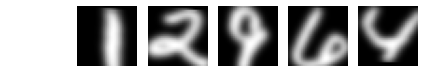

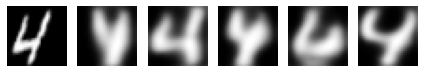

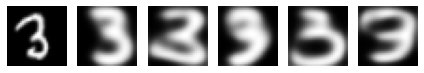

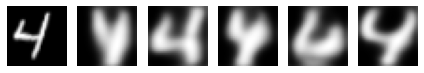

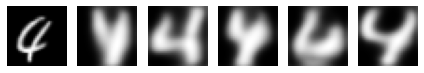

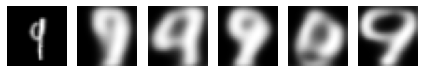

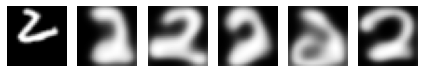

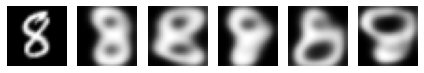

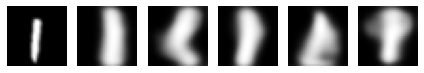

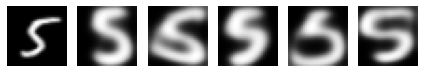

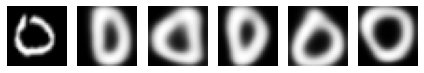

In [10]:
plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader)

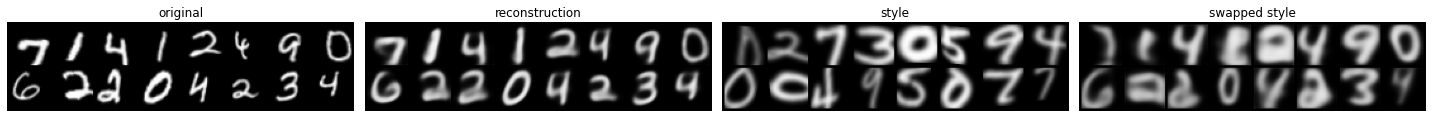

In [11]:
x_s, _ = next(iter(source_train_loader))
x_t, _ = next(iter(target_train_loader))
#xt_hat, yt_hat, (z_task, z_target), (pred_task, pred_spe) = model(x_t.cuda(), mode='all_target')
xs_hat, ys_hat, (z_task, z_source), (pred_task, pred_spe) = model(x_s.cuda(), mode='all_source')
xst = model.decode(z_task, x_t[:len(x_s)].cuda(), mode='target')
show_decoded_images(x_s[:16], xs_hat[:16], x_t[:len(x_s)][:16], xst[:16])

In [ ]:
torch.save(model, "mnist_to_usps.pth")